In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd

In [14]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from neurosim.models.oup import VOUP, gen_random_connectivity
from neurosim.models.var import gen_var1_connectivity, form_companion, ravel_companion

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
from pyuoi.linear_model.var import VAR

In [17]:
import sys
sys.path.append('../..')
from loaders import load_sabes
from utils import apply_df_filters, calc_loadings

In [7]:
# Simulate from OUP. As we downsample the signal, how does the inferred connectivity matrix compare with
# no downsampling but removing self regression?

### Simulated data

In [8]:
w, _ = gen_random_connectivity(20, n_asymptotic=0, n_white=0, sparse=False)

In [79]:
oup = VOUP(w, sigma=np.eye(w.shape[0]), connect_noise=False)

In [20]:
A = gen_var1_connectivity(A_dim=20, sparsity_w=0.25, sparsity_o=0.6)
ssm = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))

In [80]:
h = 5e-2

In [81]:
T = [10, 20, 30, 40, 50]
ds_factor = np.arange(1, 10).astype(int)
A = np.zeros((len(T), len(ds_factor), 2)).astype(np.object)
r2 = np.zeros(A.shape)
h = 5e-2
for i in range(len(T)):
    for j in range(len(ds_factor)):
        t0 = time.time()
        _, _, x = oup.sim_trajectory(10*T[i], h, burnoff=True)
        
        x = scipy.signal.decimate(x, ds_factor[j], axis=0)
        
        varmodel1 = VAR(self_regress=False, estimator='ols')
        varmodel2 = VAR(self_regress=True, estimator='ols')
                
        # Standardize and divide into train/test splits
        xtrain = x[0:int(0.8*x.shape[0]), :]
        xtest = x[int(0.8*x.shape[0]):, :]

        xtrain = StandardScaler().fit_transform(xtrain)
        xtest = StandardScaler().fit_transform(xtest)
        
        varmodel1.fit(xtrain)
        varmodel2.fit(xtrain)        
        A[i, j, 0] = varmodel1.coef_
        A[i, j, 1] = varmodel2.coef_
        
        r2[i, j, 0] = varmodel1.score(xtest)
        r2[i, j, 1] = varmodel2.score(xtest)
        
        print((i, j))
        print(time.time() - t0)

(0, 0)
0.24304652214050293
(0, 1)
0.23969507217407227
(0, 2)
0.23961949348449707
(0, 3)
0.24301791191101074
(0, 4)
0.23840665817260742
(0, 5)
0.3035435676574707
(0, 6)
0.2852315902709961
(0, 7)
0.23866629600524902
(0, 8)
0.2527163028717041
(1, 0)
0.442460298538208
(1, 1)
0.42494773864746094
(1, 2)
0.44872236251831055
(1, 3)
0.4269232749938965
(1, 4)
0.424907922744751
(1, 5)
0.420304536819458
(1, 6)
0.41815900802612305
(1, 7)
0.4826045036315918
(1, 8)
0.46482324600219727
(2, 0)
0.6334042549133301
(2, 1)
0.6254827976226807
(2, 2)
0.6206152439117432
(2, 3)
0.6369531154632568
(2, 4)
0.6125798225402832
(2, 5)
0.6140809059143066
(2, 6)
0.616309404373169
(2, 7)
0.6406569480895996
(2, 8)
0.6003975868225098
(3, 0)
0.8498969078063965
(3, 1)
0.8123657703399658
(3, 2)
0.8019688129425049
(3, 3)
0.7924017906188965
(3, 4)
0.800792932510376
(3, 5)
0.7923374176025391
(3, 6)
0.7899565696716309
(3, 7)
0.7845778465270996
(3, 8)
0.7872564792633057
(4, 0)
1.0294532775878906
(4, 1)
1.0057461261749268
(4, 2)


In [46]:
r2[..., 1]

array([[0.95502706, 0.93728018, 0.90979205, 0.89562377, 0.86947456,
        0.84574215, 0.8208633 , 0.76927195, 0.77077867],
       [0.96297019, 0.93871153, 0.92141334, 0.88503886, 0.8773099 ,
        0.83428624, 0.80990934, 0.78598878, 0.77058037],
       [0.96423863, 0.94069232, 0.91253321, 0.88346782, 0.86257388,
        0.83035733, 0.83155675, 0.78917785, 0.77418694],
       [0.96318602, 0.94274487, 0.91554329, 0.88885563, 0.87290786,
        0.84222721, 0.84301446, 0.79586061, 0.76915016],
       [0.96674144, 0.9398913 , 0.91478194, 0.89067987, 0.86020529,
        0.85158479, 0.82175963, 0.80733266, 0.77512308]])

In [ ]:
# Track distance from the identity, distance from the true dynamics matrix (discretized), and distance
# between the fits with and without the identity

In [ ]:
# (1) Distance from the identity

In [82]:
dfromeye = np.array([[np.linalg.norm(A[i, j, 1] - np.eye(20)) for j in range(A.shape[1])] for i in range(A.shape[0])])

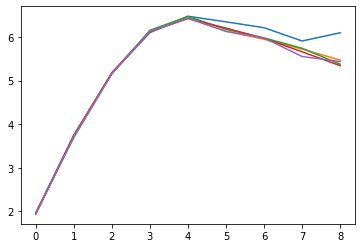

In [83]:
plt.plot(dfromeye.T)

In [84]:
# (2) Distance from the true dynamics matrix (discretized)
dfromtrue = np.array([[np.linalg.norm(A[i, j, 1] - scipy.linalg.expm(w * h)) 
                       for j in range(A.shape[1])] for i in range(A.shape[0])])

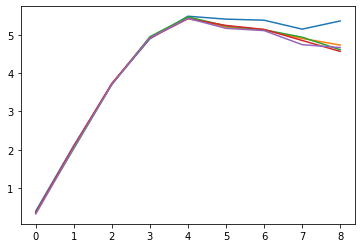

In [85]:
plt.plot(dfromtrue.T)

In [86]:
# (3) Pairwise distance between self regression and non self regression
pairwisedist = np.array([[np.linalg.norm(A[i, j, 1] - A[i, j, 0]) 
                       for j in range(A.shape[1])] for i in range(A.shape[0])])

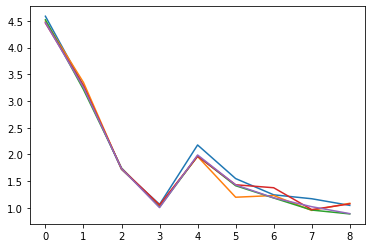

In [87]:
plt.plot(pairwisedist.T)

In [ ]:
# Nothing clear here. What does it look like in sabes dataset?

### Sabes Misc.

In [7]:
dfile = '/media/akumar/Secondary/data/sabes/indy_20160915_01.mat'

In [9]:
dat = load_sabes(dfile, 50, 0.5, filter_fn='none', filter_kwargs={}, spike_threshold=100)

In [113]:
# Test the effect of downsampling on self regression
ds_factor = np.arange(1, 10).astype(int)
A = np.zeros((len(ds_factor), 2)).astype(np.object)
r2 = np.zeros(A.shape)

for i in range(len(ds_factor)):
    t0 = time.time()
    x = np.squeeze(dat['spike_rates'])   
    x = scipy.signal.decimate(x, ds_factor[i], axis=0)
    print(x.shape)
    varmodel1 = VAR(self_regress=False, estimator='ols', order=3)
    varmodel2 = VAR(self_regress=True, estimator='ols', order=3)

    # Standardize and divide into train/test splits
    xtrain = x[0:int(0.8*x.shape[0]), :]
    xtest = x[int(0.8*x.shape[0]):, :]

    xtrain = StandardScaler().fit_transform(xtrain)
    xtest = StandardScaler().fit_transform(xtest)

    varmodel1.fit(xtrain)
    varmodel2.fit(xtrain)        
    A[i,0] = varmodel1.coef_
    A[i,1] = varmodel2.coef_

    r2[i,0] = varmodel1.score(xtest)
    r2[i,1] = varmodel2.score(xtest)

    print(i)
    print(time.time() - t0)
    

(7619, 134)
0
8.209537982940674
(3810, 134)
1
6.858747720718384
(2540, 134)
2
4.702754497528076
(1905, 134)
3
4.195364236831665
(1524, 134)
4
3.8888683319091797
(1270, 134)
5
3.8285269737243652
(1089, 134)
6
3.538790225982666
(953, 134)
7
3.46928334236145
(847, 134)
8
3.4111931324005127


In [116]:
r2[:, 1]

array([ 0.15990739,  0.0708764 , -0.01717899, -0.11775517, -0.25641872,
       -0.43781736, -0.70808217, -1.02314828, -1.4969829 ])

In [119]:
A[0, 1][0, ...]

array([[ 0.35502505,  0.01066263, -0.03173306, ..., -0.00097096,
        -0.01924232, -0.02790862],
       [ 0.0083997 ,  0.39686712,  0.02279715, ..., -0.00135654,
         0.00158461, -0.00119957],
       [-0.01580685,  0.02522408,  0.40107661, ...,  0.00463159,
         0.00875669, -0.00676803],
       ...,
       [ 0.02402361,  0.02400746, -0.00951104, ...,  0.34962589,
         0.01144373, -0.01104861],
       [-0.00707383,  0.01885652,  0.02331916, ...,  0.02200794,
         0.3914873 ,  0.02184412],
       [-0.01050616, -0.00185771, -0.01536071, ..., -0.01393885,
        -0.00885018,  0.38567066]])

In [ ]:
# Recall why we are doing this: We are seeking to improve performance on shenoy dataset. It seems like
# self regression is one way to do this, but we must be consistent across datasets. How does self regression 
# affect the community structure argument (needs to be tested in both shenoy and sabes datasets)?

In [ ]:
# Other thing to consider: What is the decoding performance of self regression look like? Correlation with
# PCA/DCA loadings? Loadings?

In [ ]:
# What does r^2 for regularized regression look like?

In [128]:
x = np.squeeze(dat['spike_rates'])   
varmodel1 = VAR(self_regress=False, estimator='ncv', penalty='scad', order=5)
varmodel2 = VAR(self_regress=True, estimator='ncv', penalty='scad', order=5)

# Standardize and divide into train/test splits
xtrain = x[0:int(0.8*x.shape[0]), :]
xtest = x[int(0.8*x.shape[0]):, :]

xtrain = StandardScaler().fit_transform(xtrain)
xtest = StandardScaler().fit_transform(xtest)

varmodel1.fit(xtrain)
varmodel2.fit(xtrain)

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

In [129]:
varmodel1.score(xtest)

-0.06719310525300883

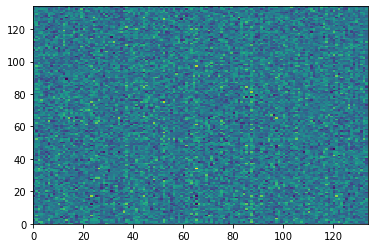

In [130]:
plt.pcolor(varmodel1.coef_[0, ...])

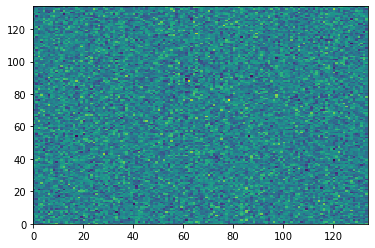

In [137]:
plt.pcolor(varmodel2.coef_[4, ...])

In [125]:
varmodel2.score(xtest)

-0.011623742297874051

In [ ]:
# For (sparse and non sparse)
# (1) Self-regress=True
# (2) self-regress=False
# (3) self-regress=True but time lags iterated

# Calculate:
# (1) Decoding performance
# (2) Loadings
# (3) Correlation with DCA/PCA loadings
# (4) How much modularity is there

### Self Regression Test: Sabes

#### Calculation

In [18]:
from decoders import lr_decoder
from tqdm import tqdm
from neurosim.models.var import form_companion, ravel_companion
from pyuoi.linear_model.var import form_lag_matrix
from utils import calc_loadings, apply_df_filters
import networkx as nx
import collections
import itertools
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.quality import modularity

In [19]:
dfile = '/media/akumar/Secondary/data/sabes/indy_20160915_01.mat' 

In [20]:
dat = load_sabes(dfile, 50, 0.5, filter_fn='none', filter_kwargs={}, spike_threshold=100)
x = np.squeeze(dat['spike_rates'])
z = np.squeeze(dat['behavior'])
varmodel1 = VAR(self_regress=False, estimator='ncv', penalty='scad', order=5)
varmodel2 = VAR(self_regress=True, estimator='ncv', penalty='scad', order=5)

# Standardize and divide into train/test splits
Xtrain = x[0:int(0.8*x.shape[0]), :]
Xtest = x[int(0.8*x.shape[0]):, :]

Ztrain = z[0:int(0.8*x.shape[0]), :]
Ztest = z[int(0.8*x.shape[0]):, :]

Xtrain = StandardScaler().fit_transform(Xtrain)
Xtest = StandardScaler().fit_transform(Xtest)

Ztrain = StandardScaler().fit_transform(Ztrain)
Ztest = StandardScaler().fit_transform(Ztest)

In [22]:
estimator = ['uoi', 'ols']
self_regress = [True, False]
estimation_score = ['gMDL', 'AIC', 'BIC'] 
order = [1, 3, 5]

param_combs = itertools.product(estimator, self_regress, estimation_score, order)

results_dict_list = []
for i, pc in tqdm(enumerate(param_combs)):
    results_dict = {}
    estimator_, self_regress_, est_score, order_ = pc
    
    results_dict['estimator'] = estimator_
    results_dict['self_regress'] = self_regress_
    results_dict['est_score'] = est_score
    results_dict['order'] = order_
        
    varmodel = VAR(estimator=estimator_, self_regress=self_regress_, order=order_,
                   estimation_score=est_score, n_boots_est=1, estimation_frac=1.)
    varmodel.fit(Xtrain)
    
    r2 = varmodel.score(Xtest)
    results_dict['r2'] = r2
    
    A_ = form_companion(varmodel.coef_)
    eig, U = scipy.linalg.eig(A_)
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
    #loadingsA = calc_loadings(U[0:2], order_)
    
    W = scipy.linalg.solve_discrete_lyapunov(A_, np.eye(A_.shape[0]))
    eig, U = np.linalg.eig(W)    
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
    #loadingsW = calc_loadings(U[0:2], order_)
    
    results_dict['A'] = A_
    #results_dict['loadingsA'] = loadingsA
    results_dict['W'] = W
    #results_dict['loadingsW'] = loadingsW
    
    # Decoding
    r2_ = np.zeros((50, 3))
    for i in range(1, 51):
        
        coef_ = U[:, 0:i]
        T = varmodel.order
        xtrain, ztrain = form_lag_matrix(Xtrain, T, y=Ztrain)
        xtest, ztest = form_lag_matrix(Xtest, T, y=Ztest)

        # Convert to array and force real valued entries
        xtrain = np.array(xtrain)
        xtest = np.array(xtest)
        ztrain = np.array(ztrain)
        ztest = np.array(ztest)
        
        xtrain = (xtrain @ coef_).astype(np.float)
        xtest = (xtest @ coef_).astype(np.float)

        r2_pos, r2_vel, r2_acc, decoder_obj = \
        lr_decoder(xtest, xtrain, ztest, ztrain, trainlag=4, testlag=4, decoding_window=3)
        r2_[i - 1, :] = [r2_pos, r2_vel, r2_acc]
            
    results_dict['r2_kin'] = r2_
    
    # Degree distribution and community structure
    
    # 1st order dynamics matrix
    G1 = nx.convert_matrix.from_numpy_array(varmodel.coef_[0, ...])
    # time series grpah
    G2 = nx.convert_matrix.from_numpy_array(np.sum(varmodel.coef_, axis=0))

    results_dict['graph_stats1'] = {}
    results_dict['graph_stats2'] = {}
    
    # Degree distribution
    degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    results_dict['graph_stats1']['dd'] = (deg, cnt)
    results_dict['graph_stats1']['wdd'] = np.array(list(dict(G1.degree(weight='weight')).values()))

    degree_sequence = sorted([d for n, d in G2.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    results_dict['graph_stats2']['dd'] = (deg, cnt)
    results_dict['graph_stats2']['wdd'] = np.array(list(dict(G2.degree(weight='weight')).values()))
    
    # Community structure (first 5 communities)
    comp = girvan_newman(G1)
    comms = []
    limited = itertools.takewhile(lambda c: len(c) <= 5, comp)
    for communities in limited:
        comms.append(tuple(sorted(c) for c in communities))
    results_dict['graph_stats1']['comms'] = comms
    results_dict['graph_stats1']['modularity'] = np.array([modularity(G1, comm) for comm in comms])
    
    comp = girvan_newman(G2)
    comms = []
    limited = itertools.takewhile(lambda c: len(c) <= 5, comp)
    for communities in limited:
        comms.append(tuple(sorted(c) for c in communities))
    results_dict['graph_stats2']['comms'] = comms
    results_dict['graph_stats2']['modularity'] = np.array([modularity(G2, comm) for comm in comms])  
    
    results_dict_list.append(results_dict)

0it [00:00, ?it/s]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

1it [01:16, 76.36s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

2it [07:13, 241.32s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

3it [18:34, 442.02s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

4it [20:03, 302.88s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

5it [25:49, 318.53s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

6it [36:54, 436.15s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

10it [52:17, 282.60s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

11it [58:13, 305.23s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

12it [1:10:28, 435.83s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

13it [1:12:04, 333.11s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

14it [1:18:11, 343.11s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

15it [1:29:58, 452.89s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

16it [1:30:36, 328.15s/it]

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Row 0
Training is over.
Row 1
Training is over.
Row 2
Training is over.
Row 3
Training is over.
Row 4
Training is over.
Row 5
Training is over.
Row 6
Training is over.
Row 7
Training is over.
Row 8
Training is over.
Row 9
Training is over.
Row 10
Training is over.
Row 11
Training is over.
Row 12
Training is over.
Row 13
Training is over.
Row 14
Training is over.
Row 15
Training is over.
Row 16
Training is over.
Row 17
Training is over.
Row 18
Training is over.
Row 19
Training is over.
Row 20
Training is over.
Row 21
Training is over.
Row 22
Training is over.
Row 23
Training is over.
Row 24
Training is over.
Row 25
Training is over.
Row 26
Training is over.
Row 27
Training is over.
Row 28
Training is over.
Row 29
Training is over.
Row 30
Training is over.
Row 31
Training is over.
Row 32
Training is over.
Row 33
Training is over.
Row 34
Training is over.
Row 35
Training is over.
Row 36
Training is over.
Row 37
Training is over.
Row 38
Training is over.
Row 39
Training is over.
Row 40
Tra

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


19it [1:47:14, 323.15s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


20it [1:50:15, 280.66s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


21it [1:53:25, 253.29s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


22it [1:56:24, 231.02s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


23it [1:59:27, 216.67s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


24it [2:02:39, 209.31s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


25it [2:05:44, 202.03s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


26it [2:09:00, 200.02s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


27it [2:12:25, 201.54s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


28it [2:15:35, 198.21s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


29it [2:18:48, 196.52s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


30it [2:22:20, 201.29s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


31it [2:25:29, 197.56s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


32it [2:28:33, 193.37s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


33it [2:31:44, 192.76s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


34it [2:34:44, 189.07s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


35it [2:37:48, 187.36s/it]

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31
Row 32
Row 33
Row 34
Row 35
Row 36
Row 37
Row 38
Row 39
Row 40
Row 41
Row 42
Row 43
Row 44
Row 45
Row 46
Row 47
Row 48
Row 49
Row 50
Row 51
Row 52
Row 53
Row 54
Row 55
Row 56
Row 57
Row 58
Row 59
Row 60
Row 61
Row 62
Row 63
Row 64
Row 65
Row 66
Row 67
Row 68
Row 69
Row 70
Row 71
Row 72
Row 73
Row 74
Row 75
Row 76
Row 77
Row 78
Row 79
Row 80
Row 81
Row 82
Row 83
Row 84
Row 85
Row 86
Row 87
Row 88
Row 89
Row 90
Row 91
Row 92
Row 93
Row 94
Row 95
Row 96
Row 97
Row 98
Row 99
Row 100
Row 101
Row 102
Row 103
Row 104
Row 105
Row 106
Row 107
Row 108
Row 109
Row 110
Row 111
Row 112
Row 113
Row 114
Row 115
Row 116
Row 117
Row 118
Row 119
Row 120
Row 121
Row 122
Row 123
Row 124
Row 125
Row 126
Row 127
Row 128
Row 129
Row 130
Row 131
Row 132
Row 133


36it [2:40:58, 268.30s/it]


In [24]:
with open('self_regresss_rd.dat', 'wb') as f:
    f.write(pickle.dumps(results_dict_list))

In [6]:
import pickle
import sys
import pdb
import numpy as np
from tqdm import tqdm
import networkx as nx
from networkx.algorithms.community.quality import modularity

In [2]:
import graph_tool as gt
from graph_tool.all import *

In [3]:
# Extract the series of VAR matrices that comprise the
# companion matrix formed by form_companion
def ravel_companion(A, d):

    n = A.shape[1]//d
    w = []

    for i in range(d):
        w.append(A[0:n, i*n:(i+1)*n])

    return w

In [4]:
def numpy_to_gt(adj):
    idx = adj.nonzero()
    weights = adj[idx]
    g = gt.Graph(directed=True)
    g.add_edge_list(np.transpose(idx))

    #add weights as an edge propetyMap
    ew = g.new_edge_property("double")
    ew.a = weights 
    g.ep['edge_weight'] = ew
    
    return g

In [5]:
with open('self_regress_rd.dat', 'rb') as f:
    results_dict_list = pickle.load(f)

In [ ]:
for i in tqdm(range(len(results_dict_list))):
    
    w = ravel_companion(results_dict_list[i]['A'], results_dict_list[i]['order'])
    if np.allclose(np.diag(w[0]), np.zeros(w[0].shape[0])):
        self_regress=False
    else:
        self_regress=True
        
    # Remove diagonls
    for ww in w:
        np.fill_diagonal(ww, 0)
            
        
    A1 = w[0]
    A2 = sum(w)
    
    # Assemble graph tools network from numpy array
    G1 = numpy_to_gt(A1)
    G2 = numpy_to_gt(A2)
    
    blkmodel1 = minimize_blockmodel_dl(G1, B_min=2)
    blkmodel2 = minimize_blockmodel_dl(G2, B_min=2)
    
    blocks1 = np.array(blkmodel1.get_blocks().get_array())
    blocks2 = np.array(blkmodel2.get_blocks().get_array())

    results_dict_list[i]['graph_stats1']['blk'] = blocks1
    results_dict_list[i]['graph_stats2']['blk'] = blocks2
    
    # Measure modularity using networkx
    G1 = nx.convert_matrix.from_numpy_array(A1)
    G2 = nx.convert_matrix.from_numpy_array(A2)

    blocks1_ = []
    for val in np.unique(blocks1):
        blocks1_.append(list(np.arange(blocks1.size)[blocks1 == val]))

    blocks2_ = []
    for val in np.unique(blocks2):
        blocks2_.append(list(np.arange(blocks2.size)[blocks2 == val]))
            
    results_dict_list[i]['graph_stats1']['blk_mod'] = modularity(G1, blocks1_)
    results_dict_list[i]['graph_stats2']['blk_mod'] = modularity(G2, blocks2_)

    
    

 86%|████████▌ | 31/36 [00:31<00:05,  1.18s/it]

In [ ]:
# Manually assign the correct self_regress parameter

In [12]:
with open('self_regress_rd.dat', 'wb') as f:
    f.write(pickle.dumps(results_dict_list))

#### Plotting

In [7]:
estimator = ['uoi', 'ols']
self_regress = [True, False]
estimation_score = ['gMDL', 'AIC', 'BIC'] 
order = [1, 3, 5]

In [8]:
with open('self_regress_rd.dat', 'rb') as f:
    results_dict_list = pickle.load(f)

In [9]:
srdf = pd.DataFrame(results_dict_list)

In [ ]:
# Decoding performance for selection methods, ols, self regress or not

> <ipython-input-11-60ba7240ae9c>(15)<module>()
     13         for k in range(df_.shape[0]):
     14             pdb.set_trace()
---> 15             w = ravel_companion(df_.iloc[k]['A'], order_)[0]
     16             if np.allclose(np.diag(w), np.zeros(w.shape[0])):
     17                 a.plot(df_.iloc[k]['r2_kin'][:, 0], label='OLS No SR')

ipdb> w1 = ravel_companion(df_.iloc[0]['A'], order_)[0]
ipdb> w1
array([[ 0.        , -0.00209044, -0.02616425, ..., -0.00777561,
        -0.01514905, -0.00481501],
       [-0.00801287,  0.        ,  0.04107386, ..., -0.01080252,
         0.00396197,  0.009606  ],
       [-0.02636621,  0.04367013,  0.        , ...,  0.00783082,
         0.02979226, -0.00668923],
       ...,
       [ 0.01260261,  0.0144591 , -0.00612171, ...,  0.        ,
         0.00610193,  0.00157628],
       [-0.00626152,  0.02292355,  0.03369103, ...,  0.01666892,
         0.        ,  0.02412452],
       [ 0.00072581,  0.00341261, -0.00489407, ...,  0.00465121,
        -

BdbQuit: 

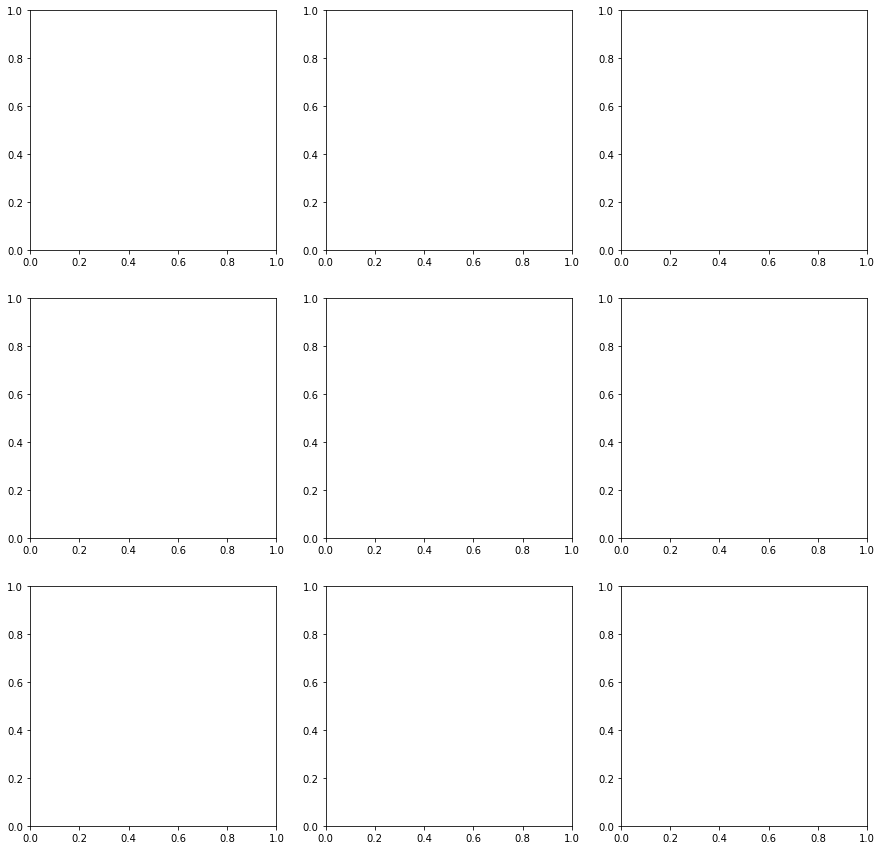

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
# Separate row for each selection method, compare to OLS on all

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        
        # OLS
        df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                               est_score=sm)

        # Forgot to properly set the self regress parameter, so we check manually here
        for k in range(df_.shape[0]):
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='OLS No SR')
            else:
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='OLS SR')
                    
        # SCAD
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)

        for k in range(df_.shape[0]):
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='SCAD %s, No SR' % sm)
            else:
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='SCAD %s, SR' % sm)
        
        # Legend
        a.legend()

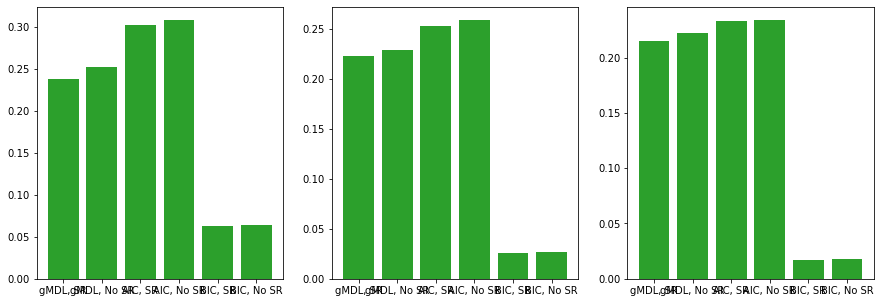

In [36]:
# Selection ratio
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, order_ in enumerate(order):
    
    selection_ratios = []
    labels = []
    
    for j, sm in enumerate(estimation_score):
        
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi', est_score=sm)
        
        # Forgot to properly set the self regress parameter, so we check manually here

        for k in range(df_.shape[0]):
            w = ravel_companion(df_.iloc[k]['A'], order_)
            sr = 0
            for ii in range(len(w)):
                sr += np.count_nonzero(w[ii])
            
            if np.allclose(np.diag(w[0]), np.zeros(w[0].shape[0])):
                sr/= order_ * (w[0].shape[0]**2 - w[0].shape[0])                    
                labels.append('%s, No SR' % sm)
            else:
                sr /= order_ * (w[0].shape[0]**2)
                labels.append('%s, SR' % sm)

            selection_ratios.append(sr)
        
        ax[i].bar(labels, selection_ratios)
            

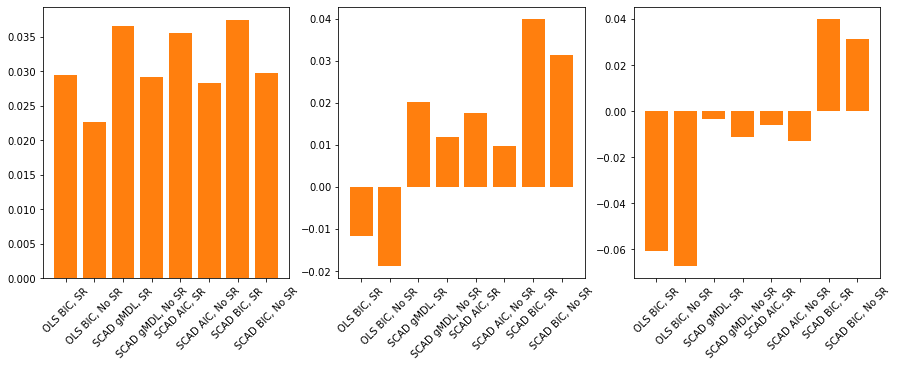

In [77]:
# Prediction R^2 - need to re-run to get this\
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, order_ in enumerate(order):
    
    r2 = []
    labels = []
    
    for estimator_ in ['ols', 'uoi']:
        
        if estimator_ == 'uoi':
    
            for j, sm in enumerate(estimation_score):

                df_ = apply_df_filters(srdf, order=order_, estimator='uoi', est_score=sm)

                # Forgot to properly set the self regress parameter, so we check manually here

                for k in range(df_.shape[0]):

                    w = ravel_companion(df_.iloc[k]['A'], order_)
                    vmodel = VAR()
                    vmodel.coef_ = np.array(w)
                    r2.append(vmodel.score(Xtest))
                    
                    
                    if np.allclose(np.diag(w[0]), np.zeros(w[0].shape[0])):
                        labels.append('SCAD %s, No SR' % sm)
                    else:
                        labels.append('SCAD %s, SR' % sm)
        else:
                    
            df_ = apply_df_filters(srdf, order=order_, estimator='ols', est_score=sm)
            for k in range(df_.shape[0]):

                w = ravel_companion(df_.iloc[k]['A'], order_)
                vmodel = VAR()
                vmodel.coef_ = np.array(w)
                r2.append(vmodel.score(Xtest))
                
                if np.allclose(np.diag(w[0]), np.zeros(w[0].shape[0])):
                    labels.append('OLS %s, No SR' % sm)
                else:
                    labels.append('OLS %s, SR' % sm)

        ax[i].bar(labels, r2)
        ax[i].set_xticklabels(labels, rotation = 45)

                    

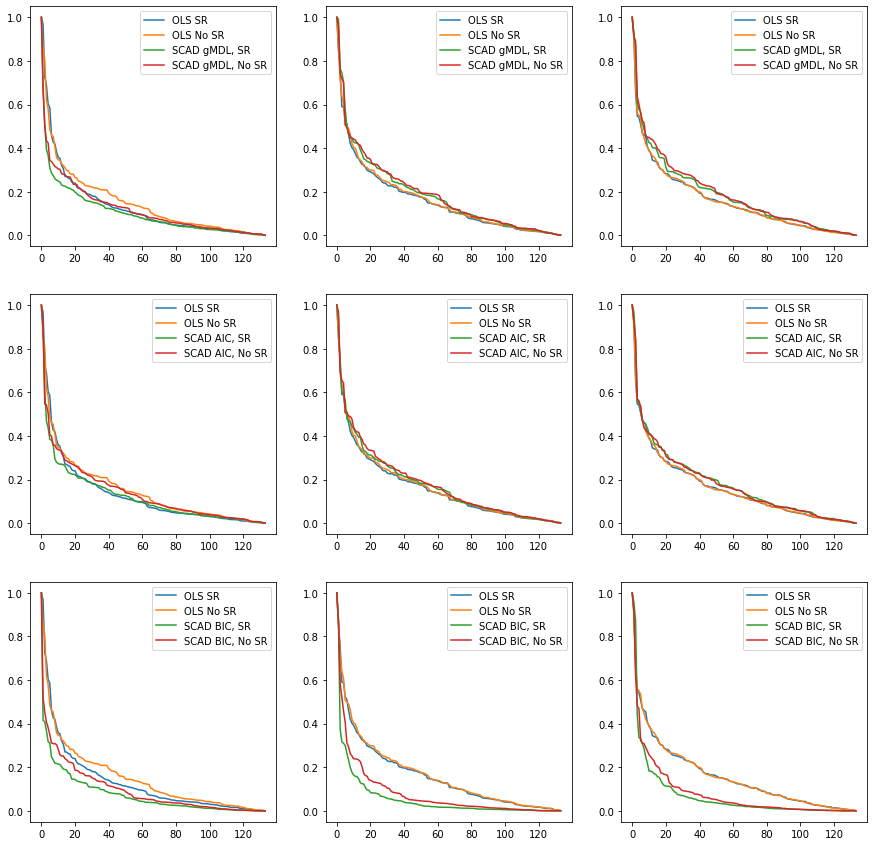

In [38]:
# Loadings on A
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        
        # OLS
        df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                               est_score=sm)

        # Forgot to properly set the self regress parameter, so we check manually here
        for k in range(df_.shape[0]):
            A = df_.iloc[k]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)
            
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(np.sort(loadings)[::-1], label='OLS No SR')
            else:
                a.plot(np.sort(loadings)[::-1], label='OLS SR')
                    
        # SCAD
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)

        for k in range(df_.shape[0]):
            A = df_.iloc[k]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)            
            
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(np.sort(loadings)[::-1], label='SCAD %s, No SR' % sm)
            else:
                a.plot(np.sort(loadings)[::-1], label='SCAD %s, SR' % sm)
        
        # Legend
        a.legend()

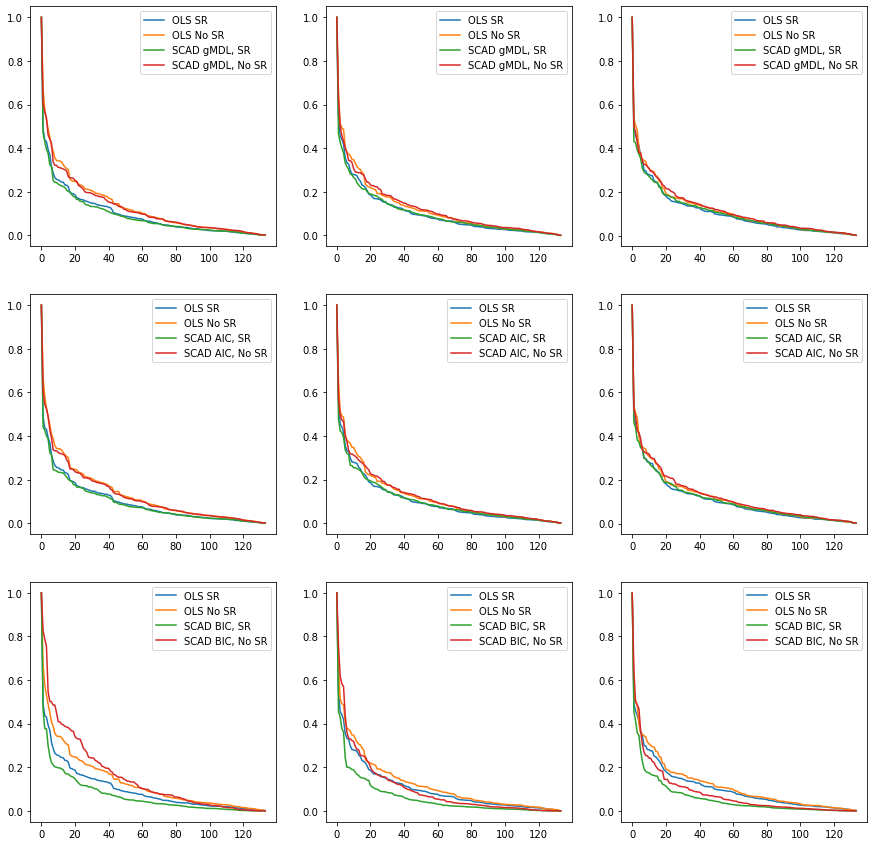

In [39]:
# Loadings on W
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        
        # OLS
        df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                               est_score=sm)

        # Forgot to properly set the self regress parameter, so we check manually here
        for k in range(df_.shape[0]):
            A = df_.iloc[k]['W']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)
            
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(np.sort(loadings)[::-1], label='OLS No SR')
            else:
                a.plot(np.sort(loadings)[::-1], label='OLS SR')
                    
        # SCAD
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)

        for k in range(df_.shape[0]):
            A = df_.iloc[k]['W']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)            
            
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(np.sort(loadings)[::-1], label='SCAD %s, No SR' % sm)
            else:
                a.plot(np.sort(loadings)[::-1], label='SCAD %s, SR' % sm)
        
        # Legend
        a.legend()

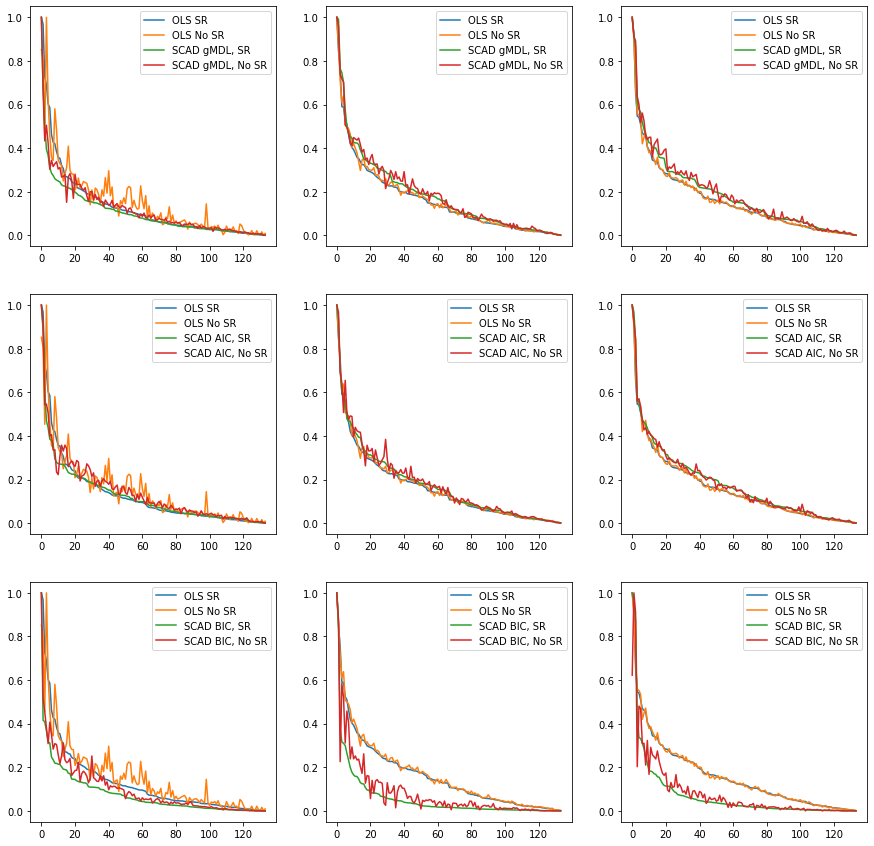

In [41]:
# Co-plot loadings for self-regression vs. no self regression (i.e. same order)
# Loadings on A
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        
        # OLS
        df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                               est_score=sm)

        # Forgot to properly set the self regress parameter, so we check manually here
        for k in range(df_.shape[0]):
            A = df_.iloc[k]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)
            
            # Common ordering for all loadings
            if k == 0:
                loading_order = np.argsort(loadings)[::-1]                
                
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(loadings[loading_order], label='OLS No SR')
            else:
                a.plot(loadings[loading_order], label='OLS SR')
                    
        # SCAD
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)

        for k in range(df_.shape[0]):
            A = df_.iloc[k]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)            
            if k == 0:
                loading_order = np.argsort(loadings)[::-1]                
            
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(loadings[loading_order], label='SCAD %s, No SR' % sm)
            else:
                a.plot(loadings[loading_order], label='SCAD %s, SR' % sm)
        
        # Legend
        a.legend()

In [ ]:
## Nice - result: Ordering of neurons unaffected

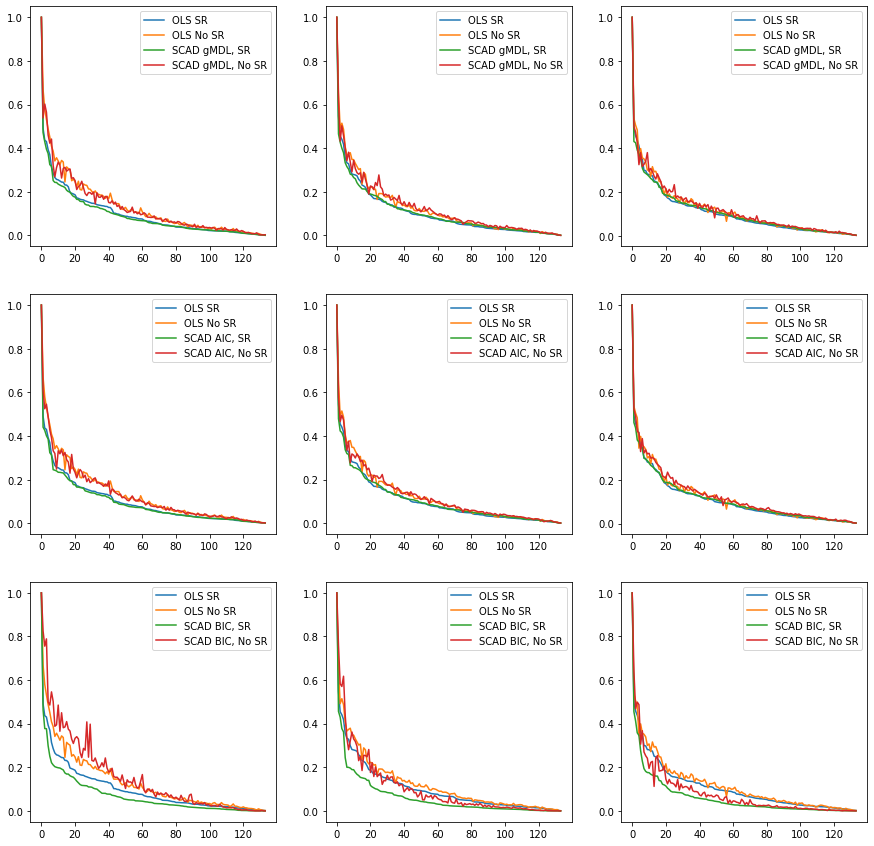

In [42]:
# Co-plot loadings for self-regression vs. no self regression
# Loadings on W
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        
        # OLS
        df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                               est_score=sm)

        # Forgot to properly set the self regress parameter, so we check manually here
        for k in range(df_.shape[0]):
            A = df_.iloc[k]['W']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)
            
            # Common ordering for all loadings
            if k == 0:
                loading_order = np.argsort(loadings)[::-1]                
                
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(loadings[loading_order], label='OLS No SR')
            else:
                a.plot(loadings[loading_order], label='OLS SR')
                    
        # SCAD
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)

        for k in range(df_.shape[0]):
            A = df_.iloc[k]['W']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)            
            if k == 0:
                loading_order = np.argsort(loadings)[::-1]                
            
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(loadings[loading_order], label='SCAD %s, No SR' % sm)
            else:
                a.plot(loadings[loading_order], label='SCAD %s, SR' % sm)
        
        # Legend
        a.legend()

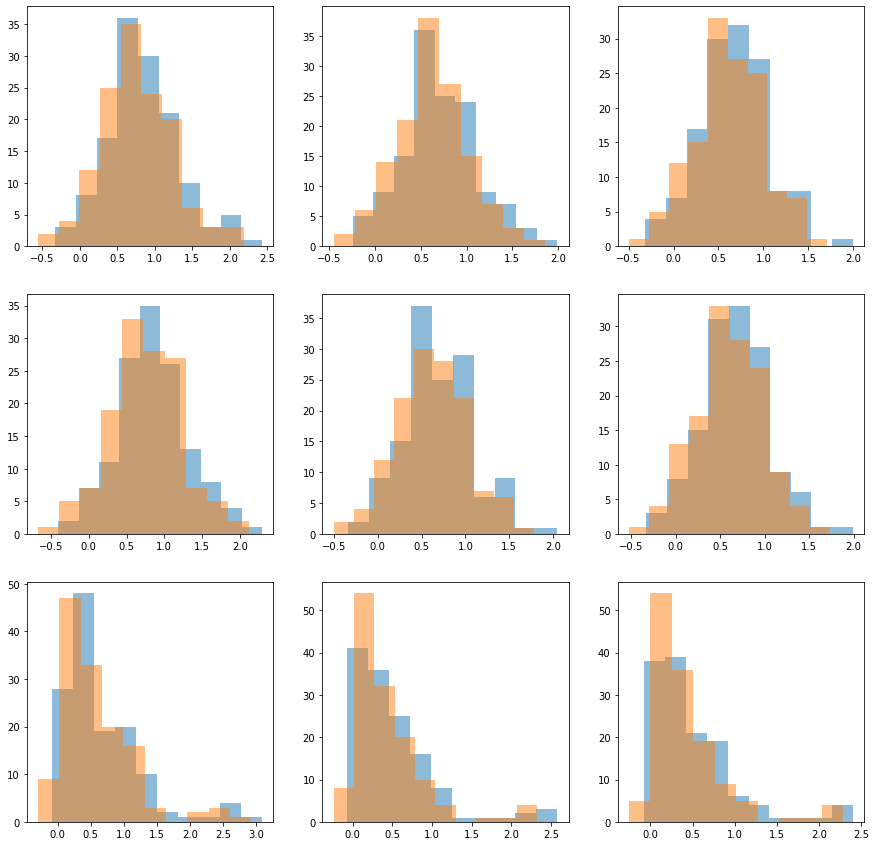

In [58]:
# Weighted degree distribution, VAR(1) matrix across orders
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)
        for k in range(df_.shape[0]):
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.hist(df_.iloc[k]['graph_stats1']['wdd'],
                       label='%s, No SR' % sm, alpha=0.5)
            else:
                a.hist(df_.iloc[k]['graph_stats1']['wdd'],
                       label='%s, SR' % sm, alpha=0.5)                

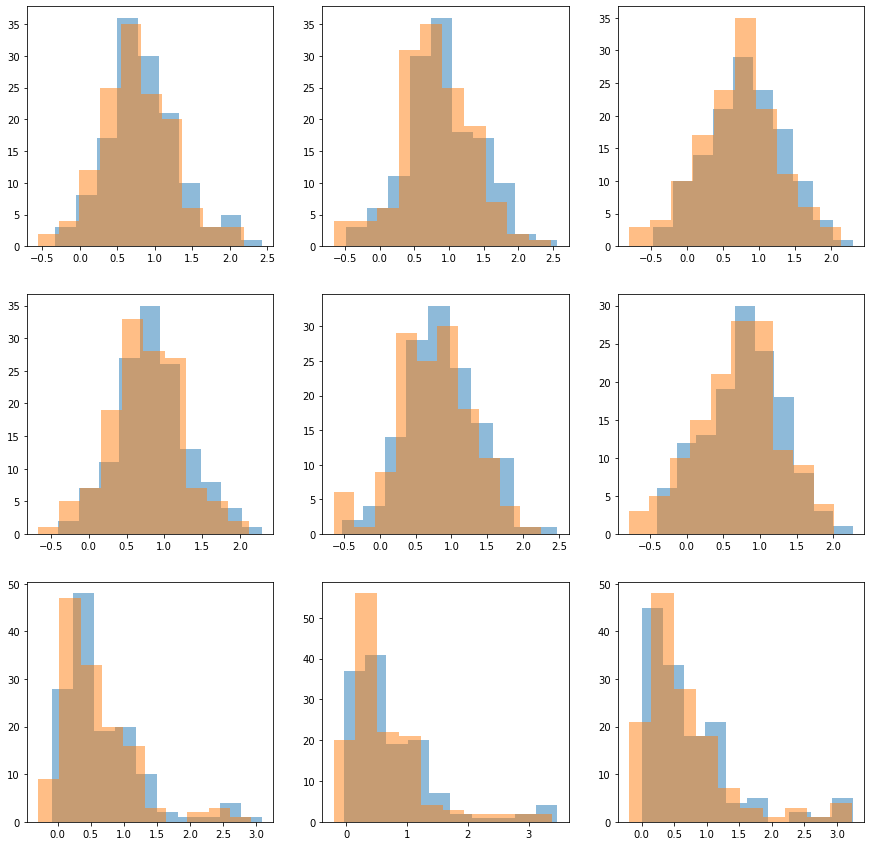

In [59]:
# Weighted degree distribution, sum of VAR matrices across orders
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)
        for k in range(df_.shape[0]):
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.hist(df_.iloc[k]['graph_stats2']['wdd'],
                       label='%s, No SR' % sm, alpha=0.5)
            else:
                a.hist(df_.iloc[k]['graph_stats2']['wdd'],
                       label='%s, SR' % sm, alpha=0.5)                

(2, 11)
(2, 11)
(2, 11)
(2, 11)
['OLS BIC, No SR', 'OLS BIC, No SR', 'SCAD gMDL, No SR', 'SCAD gMDL, No SR', 'SCAD AIC, No SR', 'SCAD AIC, No SR', 'SCAD BIC, No SR', 'SCAD BIC, No SR']
[-7.245324467411381e-05, -0.00020418324875229386, 0.23885702678174583, 0.2304442497222071, -0.00047663829948405744, -0.000492752961914559, 0.2980664314036403, 0.3066599560870169]
(2, 11)
(2, 11)
(2, 11)
(2, 11)
['OLS BIC, No SR', 'OLS BIC, No SR', 'SCAD gMDL, No SR', 'SCAD gMDL, No SR', 'SCAD AIC, No SR', 'SCAD AIC, No SR', 'SCAD BIC, No SR', 'SCAD BIC, No SR']
[-0.00012357624148525394, -5.720928204134659e-05, -0.00026128253456433, -7.798388627678338e-05, -6.805323038572469e-05, -0.00028988169201225194, 0.31144945879960617, 0.3068474712110296]
(2, 11)
(2, 11)
(2, 11)
(2, 11)
['OLS BIC, No SR', 'OLS BIC, No SR', 'SCAD gMDL, No SR', 'SCAD gMDL, No SR', 'SCAD AIC, No SR', 'SCAD AIC, No SR', 'SCAD BIC, No SR', 'SCAD BIC, No SR']
[-0.00034213727981108365, -0.0005218659428517592, -1.7377702856324607e-05, -0.00

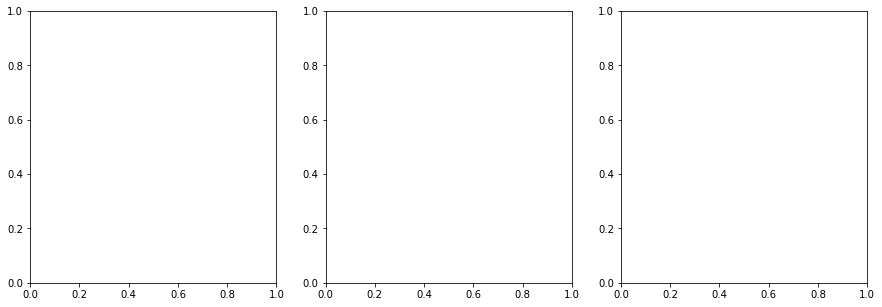

In [22]:
# Modularity
# Prediction R^2 - need to re-run to get this\
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, order_ in enumerate(order):
    mod = []
    labels = []
    
    for estimator_ in ['ols', 'uoi']:
        
        if estimator_ == 'uoi':
            for j, sm in enumerate(estimation_score):

                df_ = apply_df_filters(srdf, order=order_, estimator='uoi', est_score=sm)
                print(df_.shape)
                # Forgot to properly set the self regress parameter, so we check manually here

                for k in range(df_.shape[0]):

                    w = ravel_companion(df_.iloc[k]['A'], order_)
                    mod.append(df_.iloc[k]['graph_stats2']['blk_mod'])
                    
                    if np.allclose(np.diag(w[0]), np.zeros(w[0].shape[0])):
                        labels.append('SCAD %s, No SR' % sm)
                    else:
                        labels.append('SCAD %s, SR' % sm)
        else:
            df_ = apply_df_filters(srdf, order=order_, estimator='ols', est_score=sm)
            print(df_.shape)
            for k in range(df_.shape[0]):

                w = ravel_companion(df_.iloc[k]['A'], order_)
                mod.append(df_.iloc[k]['graph_stats2']['blk_mod'])
                
                if np.allclose(np.diag(w[0]), np.zeros(w[0].shape[0])):
                    labels.append('OLS %s, No SR' % sm)
                else:
                    labels.append('OLS %s, SR' % sm)

    print(labels)
    print(mod)
#    ax[i].bar(labels, np.abs(mod))
#        ax[i].set_xticklabels(labels, rotation = 45)

                    

In [ ]:
# Takeaways: Self regression does not affect modularity, *and* using AIC produces a very different selection 
# profile to gMDL even though the selection ratios are comparable. gMDL produces modularity

### Re-do analysis with 100 ms time bins

#### Calculation

In [23]:
dat = load_sabes(dfile, 100, 0.5, filter_fn='none', filter_kwargs={}, spike_threshold=100)
x = np.squeeze(dat['spike_rates'])
z = np.squeeze(dat['behavior'])
varmodel1 = VAR(self_regress=False, estimator='ncv', penalty='scad', order=5)
varmodel2 = VAR(self_regress=True, estimator='ncv', penalty='scad', order=5)

# Standardize and divide into train/test splits
Xtrain = x[0:int(0.8*x.shape[0]), :]
Xtest = x[int(0.8*x.shape[0]):, :]

Ztrain = z[0:int(0.8*x.shape[0]), :]
Ztest = z[int(0.8*x.shape[0]):, :]

Xtrain = StandardScaler().fit_transform(Xtrain)
Xtest = StandardScaler().fit_transform(Xtest)

Ztrain = StandardScaler().fit_transform(Ztrain)
Ztest = StandardScaler().fit_transform(Ztest)

In [30]:
estimator = ['uoi', 'ols']
self_regress = [True, False]
estimation_score = ['gMDL', 'AIC', 'BIC'] 
order = [1, 3, 5]

param_combs = itertools.product(estimator, self_regress, estimation_score, order)

results_dict_list = []
for i, pc in tqdm(enumerate(param_combs)):
    results_dict = {}
    estimator_, self_regress_, est_score, order_ = pc
    
    results_dict['estimator'] = estimator_
    results_dict['self_regress'] = self_regress_
    results_dict['est_score'] = est_score
    results_dict['order'] = order_
        
    varmodel = VAR(estimator=estimator_, self_regress=self_regress_, order=order_,
                   estimation_score=est_score, n_boots_est=1, estimation_frac=1.)
    varmodel.fit(Xtrain)
    
    r2 = varmodel.score(Xtest)
    results_dict['r2'] = r2
    
    A_ = form_companion(varmodel.coef_)
    eig, U = scipy.linalg.eig(A_)
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
#     loadingsA = calc_loadings(U[0:2], order_)
    
    W = scipy.linalg.solve_discrete_lyapunov(A_, np.eye(A_.shape[0]))
    eig, U = np.linalg.eig(W)    
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
#     loadingsW = calc_loadings(U[0:2], order_)
    
    results_dict['A'] = A_
#    results_dict['loadingsA'] = loadingsA
    results_dict['W'] = W
#    results_dict['loadingsW'] = loadingsW
    
    # Decoding
    r2_ = np.zeros((50, 3))
    for i in range(1, 51):
        
        coef_ = U[:, 0:i]
        T = varmodel.order
        xtrain, ztrain = form_lag_matrix(Xtrain, T, y=Ztrain)
        xtest, ztest = form_lag_matrix(Xtest, T, y=Ztest)

        # Convert to array and force real valued entries
        xtrain = np.array(xtrain)
        xtest = np.array(xtest)
        ztrain = np.array(ztrain)
        ztest = np.array(ztest)
        
        xtrain = (xtrain @ coef_).astype(np.float)
        xtest = (xtest @ coef_).astype(np.float)

        r2_pos, r2_vel, r2_acc, decoder_obj = \
        lr_decoder(xtest, xtrain, ztest, ztrain, trainlag=4, testlag=4, decoding_window=3)
        r2_[i - 1, :] = [r2_pos, r2_vel, r2_acc]
            
    results_dict['r2_kin'] = r2_
    
    # Degree distribution and community structure
    
    # 1st order dynamics matrix
    G1 = nx.convert_matrix.from_numpy_array(varmodel.coef_[0, ...])
    # time series grpah
    G2 = nx.convert_matrix.from_numpy_array(np.sum(varmodel.coef_, axis=0))

    results_dict['graph_stats1'] = {}
    results_dict['graph_stats2'] = {}
    
    # Degree distribution
    degree_sequence = sorted([d for n, d in G1.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    results_dict['graph_stats1']['dd'] = (deg, cnt)
    results_dict['graph_stats1']['wdd'] = np.array(list(dict(G1.degree(weight='weight')).values()))

    degree_sequence = sorted([d for n, d in G2.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    results_dict['graph_stats2']['dd'] = (deg, cnt)
    results_dict['graph_stats2']['wdd'] = np.array(list(dict(G2.degree(weight='weight')).values()))
    
    # Community structure (first 5 communities)
#     comp = girvan_newman(G1)
#     comms = []
#     limited = itertools.takewhile(lambda c: len(c) <= 5, comp)
#     for communities in limited:
#         comms.append(tuple(sorted(c) for c in communities))
#     results_dict['graph_stats1']['comms'] = comms
#     results_dict['graph_stats1']['modularity'] = np.array([modularity(G1, comm) for comm in comms])
    
#     comp = girvan_newman(G2)
#     comms = []
#     limited = itertools.takewhile(lambda c: len(c) <= 5, comp)
#     for communities in limited:
#         comms.append(tuple(sorted(c) for c in communities))
#     results_dict['graph_stats2']['comms'] = comms
#     results_dict['graph_stats2']['modularity'] = np.array([modularity(G2, comm) for comm in comms])  
    
    results_dict_list.append(results_dict)

0it [00:00, ?it/s]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

1it [00:24, 24.90s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

2it [03:20, 113.33s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

3it [10:02, 245.51s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

4it [10:27, 158.10s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

5it [13:22, 164.40s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

6it [20:04, 245.16s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

7it [20:28, 172.92s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

10it [30:42, 179.79s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

11it [33:47, 181.38s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

12it [40:46, 253.73s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

13it [41:10, 184.28s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

14it [43:59, 179.72s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

15it [50:55, 250.91s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

17it [54:15, 180.51s/it]

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/akumar/anaconda3/envs/dyn/li

In [34]:
with open('self_regress_rd100.dat', 'wb') as f:
    f.write(pickle.dumps(results_dict_list))

In [11]:
import pickle
import sys
import pdb
import numpy as np
from tqdm import tqdm
import networkx as nx
from networkx.algorithms.community.quality import modularity

In [2]:
import graph_tool as gt
from graph_tool.all import *

In [3]:
with open('self_regress_rd100.dat', 'rb') as f:
    results_dict_list = pickle.load(f)

In [5]:
# Extract the series of VAR matrices that comprise the
# companion matrix formed by form_companion
def ravel_companion(A, d):

    n = A.shape[1]//d
    w = []

    for i in range(d):
        w.append(A[0:n, i*n:(i+1)*n])

    return w

In [6]:
def numpy_to_gt(adj):
    idx = adj.nonzero()
    weights = adj[idx]
    g = gt.Graph(directed=True)
    g.add_edge_list(np.transpose(idx))

    #add weights as an edge propetyMap
    ew = g.new_edge_property("double")
    ew.a = weights 
    g.ep['edge_weight'] = ew
    
    return g

In [12]:
for i in tqdm(range(len(results_dict_list))):
    
    w = ravel_companion(results_dict_list[i]['A'], results_dict_list[i]['order'])
    if np.allclose(np.diag(w[0]), np.zeros(w[0].shape[0])):
        self_regress=False
    else:
        self_regress=True
        
    # Remove diagonls
    for ww in w:
        np.fill_diagonal(ww, 0)
            
        
    A1 = w[0]
    A2 = sum(w)
    
    # Assemble graph tools network from numpy array
    G1 = numpy_to_gt(A1)
    G2 = numpy_to_gt(A2)
    
    blkmodel1 = minimize_blockmodel_dl(G1, B_min=2)
    blkmodel2 = minimize_blockmodel_dl(G2, B_min=2)
    
    blocks1 = np.array(blkmodel1.get_blocks().get_array())
    blocks2 = np.array(blkmodel2.get_blocks().get_array())

    results_dict_list[i]['graph_stats1']['blk'] = blocks1
    results_dict_list[i]['graph_stats2']['blk'] = blocks2
    
    # Measure modularity using networkx
    G1 = nx.convert_matrix.from_numpy_array(A1)
    G2 = nx.convert_matrix.from_numpy_array(A2)

    blocks1_ = []
    for val in np.unique(blocks1):
        blocks1_.append(set(np.arange(blocks1.size)[blocks1 == val]))

    blocks2_ = []
    for val in np.unique(blocks2):
        blocks2_.append(set(np.arange(blocks2.size)[blocks2 == val]))
        
    results_dict_list[i]['graph_stats1']['blk_mod'] = modularity(G1, blocks1_)
    results_dict_list[i]['graph_stats2']['blk_mod'] = modularity(G2, blocks2_)


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


In [13]:
with open('self_regress_rd100.dat', 'wb') as f:
    f.write(pickle.dumps(results_dict_list))

#### Plotting

In [7]:
with open('self_regress_rd100.dat', 'rb') as f:
    results_dict_list = pickle.load(f)    

In [8]:
estimator = ['uoi', 'ols']
self_regress = [True, False]
estimation_score = ['gMDL', 'AIC', 'BIC'] 
order = [1, 3, 5]

In [9]:
srdf = pd.DataFrame(results_dict_list)

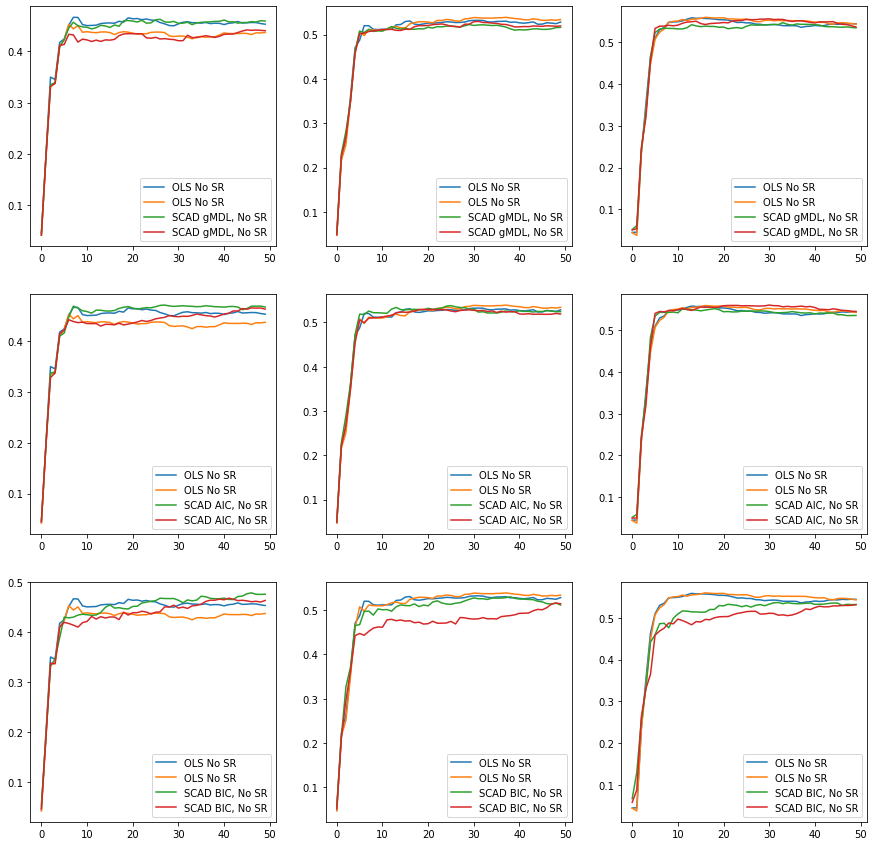

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
# Separate row for each selection method, compare to OLS on all

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]
        
        # OLS
        df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                               est_score=sm)

        # Forgot to properly set the self regress parameter, so we check manually here
        for k in range(df_.shape[0]):
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='OLS No SR')
            else:
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='OLS SR')
                    
        # SCAD
        df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                               est_score=sm)

        for k in range(df_.shape[0]):
            w = ravel_companion(df_.iloc[k]['A'], order_)[0]
            if np.allclose(np.diag(w), np.zeros(w.shape[0])):
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='SCAD %s, No SR' % sm)
            else:
                a.plot(df_.iloc[k]['r2_kin'][:, 0], label='SCAD %s, SR' % sm)
        
        # Legend
        a.legend()

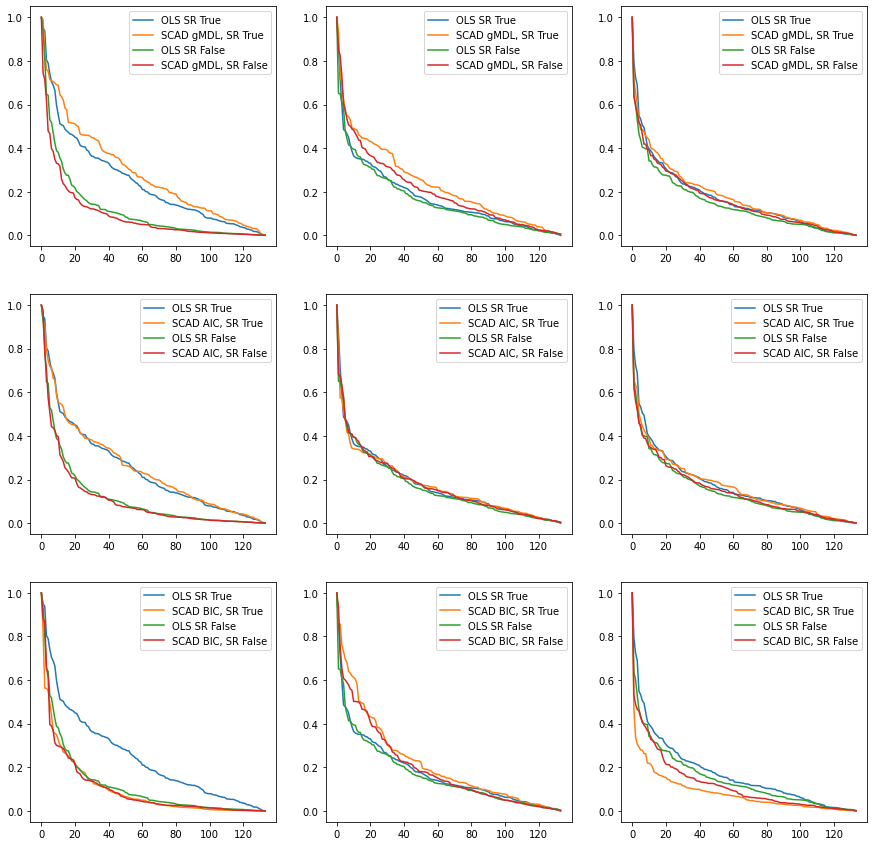

In [22]:
# Loadings on A
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]

        for self_regress_ in [True, False]:
        
            # OLS
            df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                                   est_score=sm, self_regress=self_regress_)

            A = df_.iloc[0]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)

            w = ravel_companion(df_.iloc[0]['A'], order_)[0]
            a.plot(np.sort(loadings)[::-1], label='OLS SR %s' % self_regress_)

            # SCAD
            df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                                   est_score=sm, self_regress=self_regress_)

            A = df_.iloc[0]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)            

            w = ravel_companion(df_.iloc[0]['A'], order_)[0]
            a.plot(np.sort(loadings)[::-1], label='SCAD %s, SR %s' % (sm, self_regress_))
            
        # Legend
        a.legend()

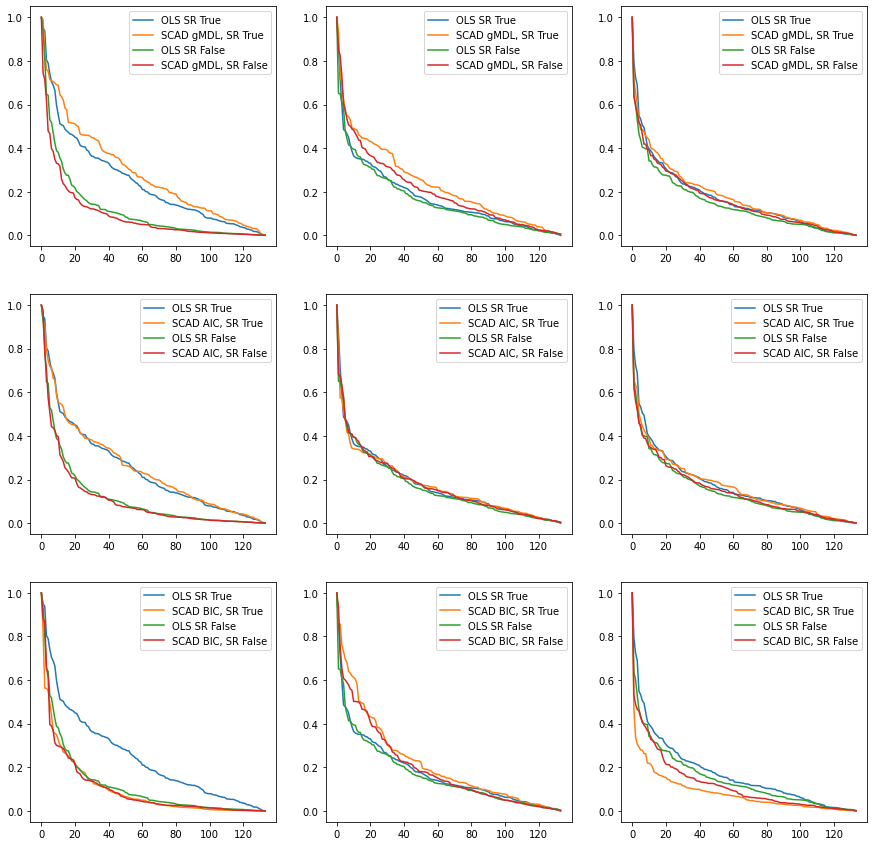

In [23]:
# Loadings on A
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, order_ in enumerate(order):
    for j, sm in enumerate(estimation_score):
        a = ax[j, i]

        for self_regress_ in [True, False]:
        
            # OLS
            df_ = apply_df_filters(srdf, order=order_, estimator='ols',
                                   est_score=sm, self_regress=self_regress_)

            A = df_.iloc[0]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)

            w = ravel_companion(df_.iloc[0]['W'], order_)[0]
            a.plot(np.sort(loadings)[::-1], label='OLS SR %s' % self_regress_)

            # SCAD
            df_ = apply_df_filters(srdf, order=order_, estimator='uoi',
                                   est_score=sm, self_regress=self_regress_)

            A = df_.iloc[0]['A']
            eig, U = np.linalg.eig(A)
            eigorder = np.argsort(np.abs(eig))[::-1]
            U = U[:, eigorder]
            loadings = calc_loadings(U[:, 0:2], order_)            

            w = ravel_companion(df_.iloc[0]['W'], order_)[0]
            a.plot(np.sort(loadings)[::-1], label='SCAD %s, SR %s' % (sm, self_regress_))
            
        # Legend
        a.legend()

In [24]:
# DOn't like it